In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import re
import os
import shutil
import glob
import zipfile
import cv2

## 1. 데이터 폴더 생성 (1회만 실행)

In [206]:
# female 엑셀파일에 id가 겹치는게 있음 -> male 엑셀파일도 있을 수 있음
# 남여 나눠서 압축 1개 풀고, 엑셀 1개 concat 하는 식으로 수행
# 이미지 이름은 1부터 rename 하였음

path= '골밀도 데이터/BoneAge/'
data_path_F = '골밀도 데이터/data_F/'
data_path_M = '골밀도 데이터/data_M/'

# xlsx파일과 zip파일 경로 추출
xls_path = glob.glob(path + "*.xlsx")
zip_path = glob.glob(path + "*.zip")

In [207]:
# 남여 zip 파일 분류
zip_path_F = [f_path for f_path in zip_path if f_path.split('/')[-1][3]=='F']
zip_path_M = [f_path for f_path in zip_path if f_path.split('/')[-1][3]=='M']

# 남여 xlsx 파일 분류
xlsx_path_F = [f_xls for f_xls in xls_path if f_xls.split('/')[-1][3]=='F']
xlsx_path_M = [m_xls for m_xls in xls_path if m_xls.split('/')[-1][3]=='M']

## 분류된 파일을 보면 연령대 순서가 동일함을 알 수 있음
# print(zip_path_M)
# print(xlsx_path_M)

# 이미지 이름을 1부터 rename
i = 1
df_f = pd.DataFrame() # female 엑셀파일 모아둘 데이터프레임 생성

# zip 함수로 female zip파일, 엑셀파일 세트로 하나씩 추출
for zip_file, xlsx_file in zip(zip_path_F, xlsx_path_F):
    zipfile.ZipFile(zip_file).extractall(data_path_F)
    xlsx_f = pd.read_excel(xlsx_file, index_col = 0)
    df_f = pd.concat([df_f, xlsx_f], axis = 0)
    
    for filename in os.listdir(data_path_F):
        # 01_F 식으로 된 파일명만 바꾸기
        if filename.split('.')[0][-1] == 'F':
            new_filename = str(i) + '.jpg'
            
            old_path = os.path.join(data_path_F, filename)
            new_path = os.path.join(data_path_F, new_filename)
            
            os.rename(old_path, new_path)
            i+= 1
        else:
            continue

df_f = df_f.reset_index(drop = True)

In [208]:
# 이중 폴더 꺼내는 것 제외하면 female 작업과 같음
for zip_file in zip_path_M:
    zipfile.ZipFile(zip_file).extractall(data_path_M)

df_m = pd.DataFrame()
folder_path = glob.glob(data_path_M + "BA*")
for in_path, xlsx_file in zip(folder_path, xlsx_path_M):
    xlsx_m = pd.read_excel(xlsx_file, index_col=0)
    df_m = pd.concat([df_m, xlsx_m], axis = 0)
    
    temp = os.listdir(in_path)
    for tmp in temp:
        os.rename(in_path + '/' + tmp, data_path_M + str(i) + '.jpg')
        i+= 1
    
    os.rmdir(in_path)
    
df_m = df_m.reset_index(drop = True)

In [209]:
# 두 데이터를 합치기 위한 data 폴더 생성
merged_folder = '골밀도 데이터/data/'
os.makedirs(merged_folder, exist_ok=True)

# data_F의 이미지를 data 폴더로 이동
for filename in os.listdir(data_path_F):
    source_path = os.path.join(data_path_F, filename)
    destination_path = os.path.join(merged_folder, filename)
    shutil.move(source_path, destination_path)
    
# data_M의 이미지를 data 폴더로 이동
for filename in os.listdir(data_path_M):
    source_path = os.path.join(data_path_M, filename)
    destination_path = os.path.join(merged_folder, filename)
    shutil.move(source_path, destination_path)

# 빈 폴더 제거
os.rmdir(data_path_F)
os.rmdir(data_path_M)

In [210]:
# 남여 데이터프레임 합치고 필요한 열만 가져옴
df = pd.concat([df_f, df_m], axis = 0).reset_index(drop = True)
df['No'] = df.index + 1
df['boneage'] = (df['BA 1'] + df['BA 2']) / 2
df['성별'] = df['성별'].map({2 : 'F', 1:'M'})

df_final = df[['No', '성별', 'boneage']]
df_final.columns = ['id', 'gender', 'boneage']
df_final

,id,gender,boneage
0,1,F,9.750
1,2,F,10.750
2,3,F,11.125
3,4,F,10.125
4,5,F,9.875
...,...,...,...
1232,1233,M,9.375
1233,1234,M,8.750
1234,1235,M,9.000
1235,1236,M,9.125


In [211]:
df_final.to_csv('골밀도 데이터/total_data.csv', index = 0)

### __train, test 셋 분리__

In [212]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df_final, test_size=0.2, random_state = 42, stratify = df_final['gender'])
train_df.to_csv('골밀도 데이터/train_data.csv', index = 0)
test_df.to_csv('골밀도 데이터/test_data.csv', index = 0)

In [213]:
train_id = train_df.id.values.tolist()
test_id = test_df.id.values.tolist()

# train_image와 test_image 폴더 생성
data_folder = '골밀도 데이터/data/'
train_image_folder = '골밀도 데이터/train_image/'
test_image_folder = '골밀도 데이터/test_image/'

os.makedirs(train_image_folder, exist_ok=True)
os.makedirs(test_image_folder, exist_ok=True)

In [ ]:
# # train 데이터의 이미지 이동
for user_id in train_id:
    source_path = os.path.join(data_folder, f'{user_id}.jpg')
    destination_path = os.path.join(train_image_folder, f'{user_id}.jpg')
    
    # 이미지 이동
    shutil.move(source_path, destination_path)
    
# test 데이터의 이미지 이동
for user_id in test_id:
    source_path = os.path.join(data_folder, f'{user_id}.jpg')
    destination_path = os.path.join(test_image_folder, f'{user_id}.jpg')
    
    # 이미지 이동
    shutil.move(source_path, destination_path)

# os.rmdir('골밀도 데이터/data/') Thumb.db 라는 숨김파일이 있어 빈 폴더 지우는 코드로 지워지지 않음
shutil.rmtree('골밀도 데이터/data/', ignore_errors=True) # 폴더와 안의 내용을 강제로 지우는 코드

## 2. 이미지 전처리
(여기서부터 실행하면 됨)

In [222]:
df = pd.read_csv('골밀도 데이터/train_data.csv')
df.head()

,id,gender,boneage
0,98,F,12.125
1,1162,M,7.125
2,636,M,10.500
3,990,M,4.125
4,618,M,9.625


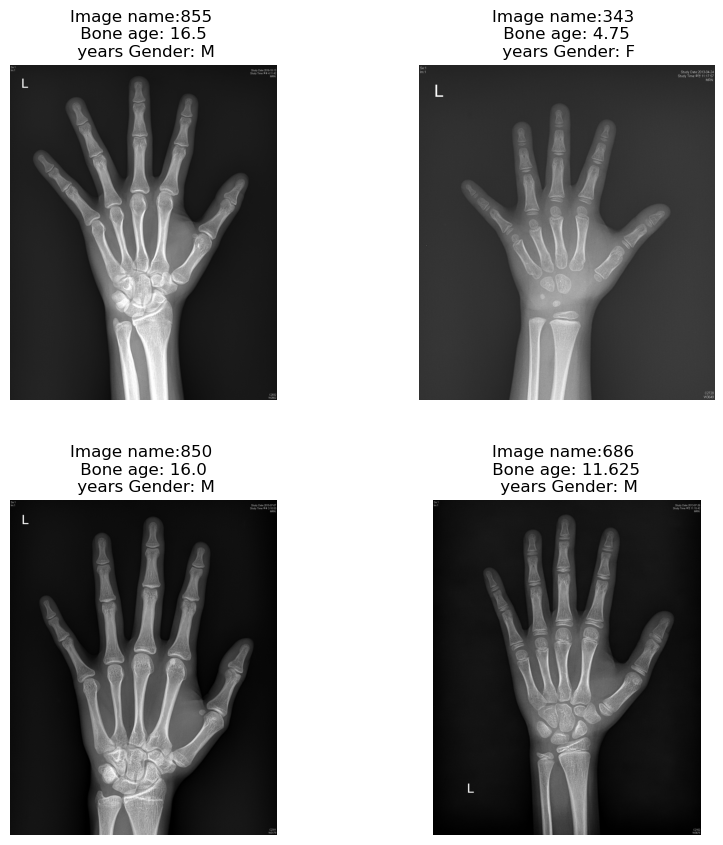

In [221]:
import matplotlib.image as mping
fig, axes = plt.subplots(2,2, figsize = (10, 10))
plt.subplots_adjust(hspace=0.3)
i = 0
for filename, boneage, gender in df[['id', 'boneage', 'gender']].sample(4).values:
    img = mping.imread('골밀도 데이터/train_image/' + str(filename) + '.jpg')
    axes[i//2,i%2].imshow(img)
    axes[i//2,i%2].set_title('Image name:{} \n Bone age: {} \n years Gender: {}'.format(filename, boneage, gender))
    axes[i//2,i%2].axis('off')
    i += 1
    
plt.show()

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from  keras.applications.xception import preprocess_input 

In [52]:
data_path = '골밀도 데이터/data/'

In [53]:
img_path = data_path + str(df.ID[0]) +'_M.jpg'
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
img.shape #shape 확인

(1560, 1344)

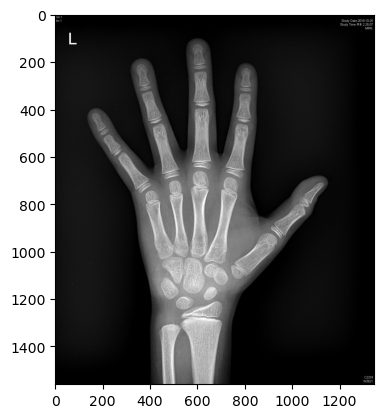

In [54]:
plt.imshow(img, 'gray')
plt.show()

__Resize__

In [55]:
#이미지 가로 세로 비율 확인
img.shape[0]/img.shape[1]

1.1607142857142858

In [58]:
#이미지 사이즈 재설정 (기존 1.25비율 유지)
resized_img=cv2.resize(img,(1024,1280))

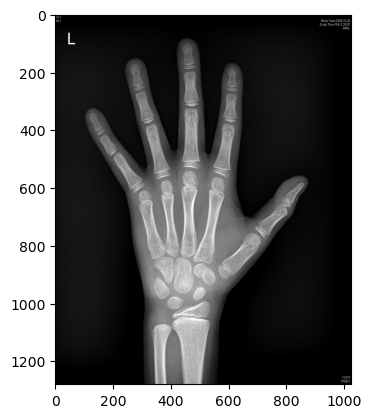

In [59]:
#resized 이미지 확인
plt.imshow(resized_img,"gray")

__Normalize__

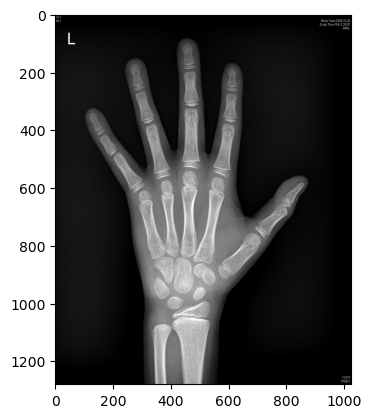

In [61]:
#이미지 min max 정규화
normal_img=cv2.normalize(resized_img, None, 0, 255, cv2.NORM_MINMAX)
plt.imshow(normal_img,"gray")

__Denoise__

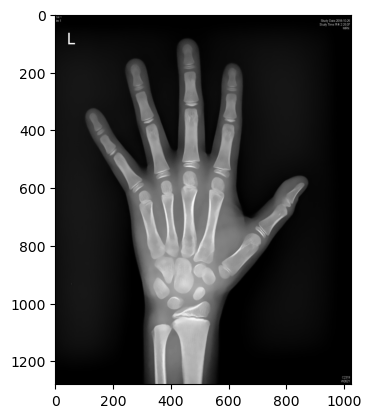

In [63]:
#이미지 노이즈 제거
    #제거 강도: 20
    #templateWindowSize :5
    #searchWindowSize : 15
denoise_img=cv2.fastNlMeansDenoising(normal_img, None, 20, 5, 15)
plt.imshow(denoise_img,"gray")

__Equalize__

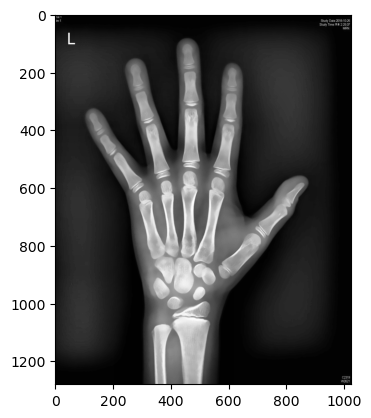

In [64]:
#이미지 평탄화
    #cv2.equalizeHist 사용시 전체 기준이므로 contrast가 날아가는 문제 발생
    #따라서 bin 구간 나누어 평탄화 가능한 clahe로 평탄화 수행
    #clipLimit: 2
    #tileGridSize: 5 x 5
clahe = cv2.createCLAHE(clipLimit=2, tileGridSize=(5,5))
equal_img=clahe.apply(denoise_img)
plt.imshow(equal_img,"gray")